In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Generate synthetic dataset
np.random.seed(42)
X = np.random.rand(1000, 2) * 4 - 2  # Points in [-2, 2] x [-2, 2]
y = (X[:, 0]**2 + X[:, 1]**2 > 5).astype(np.float32)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Training with No Regularization
Epoch [10/50], Loss: 0.0463
Epoch [20/50], Loss: 0.0546
Epoch [30/50], Loss: 0.0447
Epoch [40/50], Loss: 0.0546
Epoch [50/50], Loss: 0.0321
Accuracy: 0.9770

Training with L1 Regularization
Epoch [10/50], Loss: 0.4522
Epoch [20/50], Loss: 0.4330
Epoch [30/50], Loss: 0.4334
Epoch [40/50], Loss: 0.4339
Epoch [50/50], Loss: 0.4406
Accuracy: 0.8820

Training with L2 Regularization
Epoch [10/50], Loss: 0.1166
Epoch [20/50], Loss: 0.1276
Epoch [30/50], Loss: 0.1266
Epoch [40/50], Loss: 0.1191
Epoch [50/50], Loss: 0.1089
Accuracy: 0.9760

Training with Dropout
Epoch [10/50], Loss: 0.2033
Epoch [20/50], Loss: 0.1759
Epoch [30/50], Loss: 0.1434
Epoch [40/50], Loss: 0.1170
Epoch [50/50], Loss: 0.1089
Accuracy: 0.9830


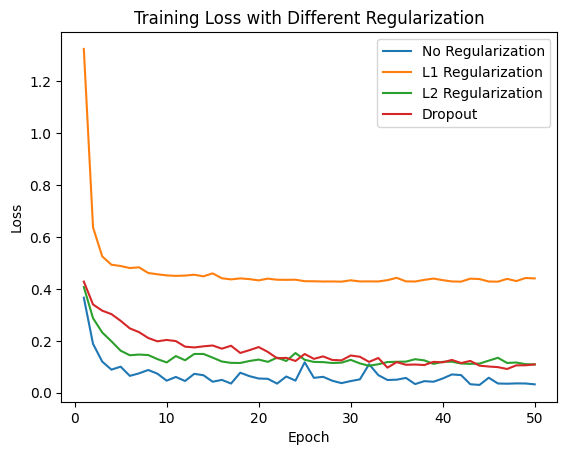

In [3]:


# Define a neural network with configurable regularization
class RegularizedNN(nn.Module):
    def __init__(self, dropout_p=0.0):
        super(RegularizedNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Dropout(dropout_p),  # Dropout layer
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Function to compute L1 regularization loss
def l1_loss(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

# Experiment with different regularization methods
configurations = [
    {"name": "No Regularization", "l1_lambda": 0.0, "l2_lambda": 0.0, "dropout_p": 0.0},
    {"name": "L1 Regularization", "l1_lambda": 0.01, "l2_lambda": 0.0, "dropout_p": 0.0},
    {"name": "L2 Regularization", "l1_lambda": 0.0, "l2_lambda": 0.01, "dropout_p": 0.0},
    {"name": "Dropout", "l1_lambda": 0.0, "l2_lambda": 0.0, "dropout_p": 0.5},
]

results = {}
for config in configurations:
    print(f"\nTraining with {config['name']}")
    model = RegularizedNN(dropout_p=config['dropout_p'])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=config['l2_lambda'])
    
    # Training loop
    num_epochs = 50
    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            if config['l1_lambda'] > 0:
                loss += l1_loss(model, config['l1_lambda'])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Evaluate accuracy
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = (outputs >= 0.5).float()
        accuracy = (predictions == y_tensor).float().mean()
        print(f"Accuracy: {accuracy:.4f}")
    
    results[config['name']] = losses

# Plot loss curves
for name, losses in results.items():
    plt.plot(range(1, num_epochs + 1), losses, label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss with Different Regularization")
plt.legend()
plt.show()